In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob # For sentiment analysis
import os

# --- Configuration ---
# Path to your raw analyst ratings CSV (news data)
news_data_file_path = '../data/raw_analyst_ratings.csv'

# Paths to your 7 stock price data files (same as in Task 2)
stock_data_files = {
    'AAPL': '../data/AAPL_historical_data.csv',
    'MSFT': '../data/MSFT_historical_data.csv',
    'GOOG': '../data/GOOG_historical_data.csv',
    'AMZN': '../data/AMZN_historical_data.csv',
    'TSLA': '../data/TSLA_historical_data.csv',
    'NVDA': '../data/NVDA_historical_data.csv',
    'META': '../data/META_historical_data.csv',
    # Ensure these paths are correct for your system
}

# Directory to save plots for Task 3
correlation_plots_dir = './correlation_plots'
os.makedirs(correlation_plots_dir, exist_ok=True)

# --- Load News Data ---
print("--- Loading News Data ---")
try:
    df_news = pd.read_csv(news_data_file_path)
    print("News data loaded successfully.")
    print("\nNews Data Head:")
    print(df_news.head())
    print("\nNews Data Info:")
    df_news.info()
except FileNotFoundError:
    print(f"Error: News data file '{news_data_file_path}' not found. Please check the path.")
    exit()
except Exception as e:
    print(f"An error occurred while loading news data: {e}")
    exit()

# --- Load and Pre-Process Stock Data (Re-using functions from Task 2 for self-containment) ---
print("\n--- Loading and Pre-processing Stock Data (Re-running Task 2 logic) ---")

def load_and_prepare_stock_data_for_task3(stock_files_dict):
    """Loads, cleans, and prepares stock data from multiple CSVs, adding STOCK_SYMBOL."""
    all_stocks_df = []
    for symbol, file_path in stock_files_dict.items():
        try:
            df_single_stock = pd.read_csv(file_path)
            df_single_stock['Stock Symbol'] = symbol
            all_stocks_df.append(df_single_stock)
        except Exception as e:
            print(f"Warning: Could not load data for {symbol} from {file_path}: {e}")
            continue

    if not all_stocks_df:
        print("No stock data loaded.")
        return None

    df_raw_combined = pd.concat(all_stocks_df, ignore_index=True)

    df_cleaned = df_raw_combined.copy()
    df_cleaned.columns = [col.upper().replace(' ', '_') for col in df_cleaned.columns]

    df_cleaned['DATE'] = pd.to_datetime(df_cleaned['DATE'], errors='coerce')
    df_cleaned.dropna(subset=['DATE'], inplace=True)
    df_cleaned.sort_values(by=['STOCK_SYMBOL', 'DATE'], inplace=True)
    df_cleaned.set_index('DATE', inplace=True)

    df_cleaned = df_cleaned.groupby('STOCK_SYMBOL', group_keys=False).apply(lambda group: group.fillna(method='ffill'))
    df_cleaned.dropna(inplace=True)

    numerical_cols = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ_CLOSE', 'VOLUME', 'DIVIDENDS', 'STOCK_SPLITS']
    for col in numerical_cols:
        if col in df_cleaned.columns:
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
    df_cleaned.dropna(subset=['OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJ_CLOSE', 'VOLUME'], inplace=True)

    return df_cleaned

# Load and prepare stock data for the current task
df_stocks = load_and_prepare_stock_data_for_task3(stock_data_files)
if df_stocks is None:
    exit()

print("Stock data loaded and basic cleaning applied for correlation.")
print("\nStock Data Head (after cleaning):")
print(df_stocks.head())

--- Loading News Data ---
News data loaded successfully.

News Data Head:
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                        date stock  
0  2020-06-05 10:30:54-04:00 

C:\Users\Perserverence\AppData\Local\Temp\ipykernel_31212\2488353470.py:73: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_cleaned = df_cleaned.groupby('STOCK_SYMBOL', group_keys=False).apply(lambda group: group.fillna(method='ffill'))
C:\Users\Perserverence\AppData\Local\Temp\ipykernel_31212\2488353470.py:73: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('STOCK_SYMBOL', group_keys=False).apply(lambda group: group.fillna(method='ffill'))


Stock data loaded and basic cleaning applied for correlation.

Stock Data Head (after cleaning):
                OPEN      HIGH       LOW     CLOSE  ADJ_CLOSE     VOLUME  \
DATE                                                                       
1980-12-12  0.128348  0.128906  0.128348  0.128348   0.098943  469033600   
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   

            DIVIDENDS  STOCK_SPLITS STOCK_SYMBOL  
DATE                                              
1980-12-12        0.0           0.0         AAPL  
1980-12-15        0.0           0.0         AAPL  
1980-12-16        0.0           0.0         AAPL  
1980-12-17        0.0           0.0         AAPL  
1980-12-18        0.0           0.0         AAPL  


Perform Sentiment Analysis on News Headlines

In [2]:
# --- Perform Sentiment Analysis ---
print("\n--- Performing Sentiment Analysis on News Headlines ---")

# Clean and prepare news data for sentiment analysis
df_news['headline'] = df_news['headline'].fillna('').astype(str)
df_news['date'] = pd.to_datetime(df_news['date'], errors='coerce')
df_news.dropna(subset=['date', 'stock'], inplace=True) # Ensure date and stock are present
df_news.rename(columns={'stock': 'STOCK_SYMBOL'}, inplace=True) # Match stock symbol column name

# Function to get sentiment from a text
def get_sentiment_polarity(text):
    return TextBlob(text).sentiment.polarity # Polarity ranges from -1 (negative) to 1 (positive)

# Apply sentiment analysis
df_news['sentiment_polarity'] = df_news['headline'].apply(get_sentiment_polarity)

print("Sentiment analysis applied to news headlines.")
print("\nNews Data with Sentiment (Head):")
print(df_news.head())

# Aggregate daily sentiment per stock
# We'll take the mean sentiment polarity for all articles on a given day for a given stock
daily_sentiment = df_news.groupby(['STOCK_SYMBOL', df_news['date'].dt.date])['sentiment_polarity'].mean().reset_index()
daily_sentiment.rename(columns={'date': 'DATE'}, inplace=True)
daily_sentiment['DATE'] = pd.to_datetime(daily_sentiment['DATE']) # Convert date back to datetime for merging

print("\nDaily aggregated sentiment per stock (Head):")
print(daily_sentiment.head())
print("\nDaily aggregated sentiment (Info):")
daily_sentiment.info()


--- Performing Sentiment Analysis on News Headlines ---
Sentiment analysis applied to news headlines.

News Data with Sentiment (Head):
   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

   

*** #Prepare Stock Data for Merging

In [3]:
# --- Prepare Stock Data for Merging ---
print("\n--- Preparing Stock Data for Merging ---")

def calculate_stock_metrics_for_correlation(df):
    """
    Calculates daily returns for stock data, essential for correlation.
    Assumes df is already cleaned and indexed by Date with STOCK_SYMBOL column.
    """
    if df is None or df.empty:
        print("Stock DataFrame is empty, cannot calculate metrics.")
        return None

    # Calculate Daily Returns per stock using Adj Close
    # We need to preserve the multi-index for proper pct_change calculation within groups
    df['Daily_Return'] = df.groupby('STOCK_SYMBOL')['ADJ_CLOSE'].pct_change()

    # Drop NaNs introduced by pct_change (the first return for each stock)
    df.dropna(subset=['Daily_Return'], inplace=True)
    return df

df_stocks_final = calculate_stock_metrics_for_correlation(df_stocks.copy())

if df_stocks_final is None or df_stocks_final.empty:
    print("Stock data is empty after calculating returns. Cannot proceed with correlation.")
    exit()

print("Stock daily returns calculated.")
print("\nStock Data with Daily Returns (Head):")
print(df_stocks_final.head())



--- Preparing Stock Data for Merging ---
Stock daily returns calculated.

Stock Data with Daily Returns (Head):
                OPEN      HIGH       LOW     CLOSE  ADJ_CLOSE     VOLUME  \
DATE                                                                       
1980-12-15  0.122210  0.122210  0.121652  0.121652   0.093781  175884800   
1980-12-16  0.113281  0.113281  0.112723  0.112723   0.086898  105728000   
1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089049   86441600   
1980-12-18  0.118862  0.119420  0.118862  0.118862   0.091630   73449600   
1980-12-19  0.126116  0.126674  0.126116  0.126116   0.097223   48630400   

            DIVIDENDS  STOCK_SPLITS STOCK_SYMBOL  Daily_Return  
DATE                                                            
1980-12-15        0.0           0.0         AAPL     -0.052171  
1980-12-16        0.0           0.0         AAPL     -0.073398  
1980-12-17        0.0           0.0         AAPL      0.024751  
1980-12-18        0.0        

Merge Data for Correlation Analysis

In [4]:
# --- Merge Data for Correlation ---
print("\n--- Merging News Sentiment and Stock Data ---")

# Ensure both DataFrames have the same index structure for merging on DATE
# df_stocks_final has DATE as index, STOCK_SYMBOL as column
# daily_sentiment has DATE as column, STOCK_SYMBOL as column. Let's set index for daily_sentiment
daily_sentiment.set_index('DATE', inplace=True)

# Perform the merge. Using an outer merge to see unmatched dates/symbols, then filter.
# Or, use inner merge to only keep where both news and stock data exist. Inner is safer for correlation.
df_merged = pd.merge(
    df_stocks_final[['STOCK_SYMBOL', 'Daily_Return']], # Only need stock symbol and daily return from stocks
    daily_sentiment[['STOCK_SYMBOL', 'sentiment_polarity']],
    on=['DATE', 'STOCK_SYMBOL'],
    how='inner' # Only keep rows where both sentiment and stock data exist for the same date and symbol
)

print("Data merged successfully.")
print("\nMerged DataFrame Head:")
print(df_merged.head())
print("\nMerged DataFrame Info:")
df_merged.info()

if df_merged.empty:
    print("Warning: Merged DataFrame is empty. This might mean no overlapping dates/symbols between news and stock data.")
    print("Check your date ranges and stock symbols in both datasets.")



--- Merging News Sentiment and Stock Data ---
Data merged successfully.

Merged DataFrame Head:
           STOCK_SYMBOL  Daily_Return  sentiment_polarity
DATE                                                     
2020-06-09         AAPL      0.031578            0.088333
2020-06-10         AAPL      0.025727            0.166919
2020-06-09         AMZN      0.030427           -0.020833
2020-06-10         AMZN      0.017913            0.204798
2020-06-04         GOOG     -0.016848            0.000000

Merged DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2020-06-09 to 2020-06-10
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   STOCK_SYMBOL        14 non-null     object 
 1   Daily_Return        14 non-null     float64
 2   sentiment_polarity  14 non-null     float64
dtypes: float64(2), object(1)
memory usage: 448.0+ bytes


Perform Correlation Analysis

In [5]:
# --- Perform Correlation Analysis ---
print("\n--- Performing Correlation Analysis ---")

# Calculate correlation for each stock
correlation_results = df_merged.groupby('STOCK_SYMBOL').apply(
    lambda x: x['Daily_Return'].corr(x['sentiment_polarity'])
).rename('Correlation_Sentiment_Return')

print("\nCorrelation between Daily Return and Sentiment Polarity for each stock:")
print(correlation_results)

# Convert to DataFrame for better presentation/saving
correlation_df = correlation_results.reset_index()
correlation_df.columns = ['STOCK_SYMBOL', 'Correlation_Sentiment_Return']
print("\nCorrelation Results DataFrame:")
print(correlation_df)




--- Performing Correlation Analysis ---

Correlation between Daily Return and Sentiment Polarity for each stock:
STOCK_SYMBOL
AAPL   -1.000000
AMZN   -1.000000
GOOG   -0.089448
NVDA    0.175712
TSLA         NaN
Name: Correlation_Sentiment_Return, dtype: float64

Correlation Results DataFrame:
  STOCK_SYMBOL  Correlation_Sentiment_Return
0         AAPL                     -1.000000
1         AMZN                     -1.000000
2         GOOG                     -0.089448
3         NVDA                      0.175712
4         TSLA                           NaN


c:\Users\Perserverence\Documents\Python_Scripts\financial-analysis-task1\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3037: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Perserverence\Documents\Python_Scripts\financial-analysis-task1\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\Perserverence\Documents\Python_Scripts\financial-analysis-task1\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:2894: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\Perserverence\AppData\Local\Temp\ipykernel_31212\1065957319.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or 

Interpret and Visualize Correlation Results


--- Interpreting and Visualizing Correlation Results ---


C:\Users\Perserverence\AppData\Local\Temp\ipykernel_31212\4108829058.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='STOCK_SYMBOL', y='Correlation_Sentiment_Return', data=correlation_df, palette='coolwarm')


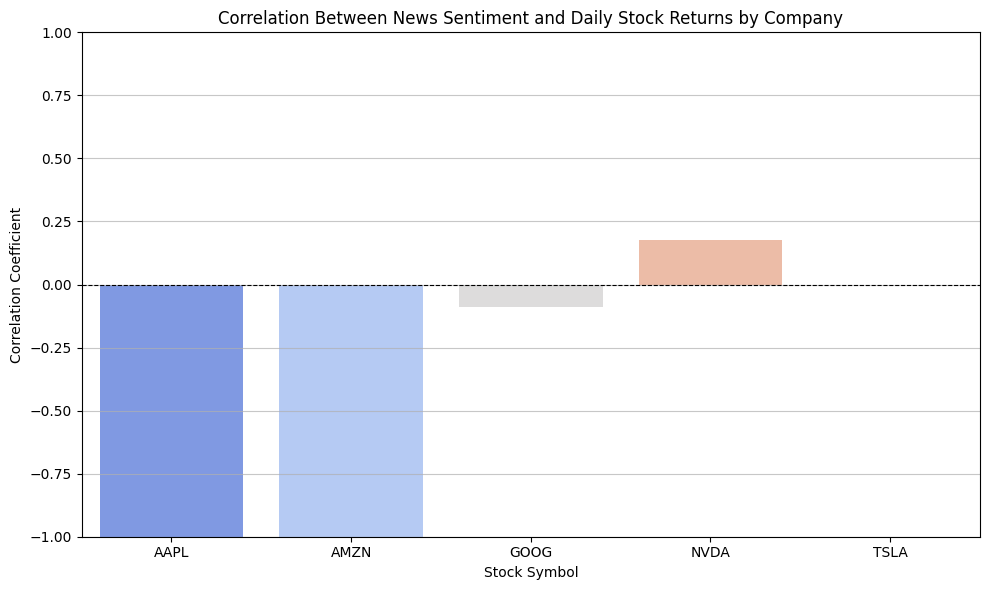

Correlation bar chart saved to ./correlation_plots\sentiment_return_correlation_bar_chart.png


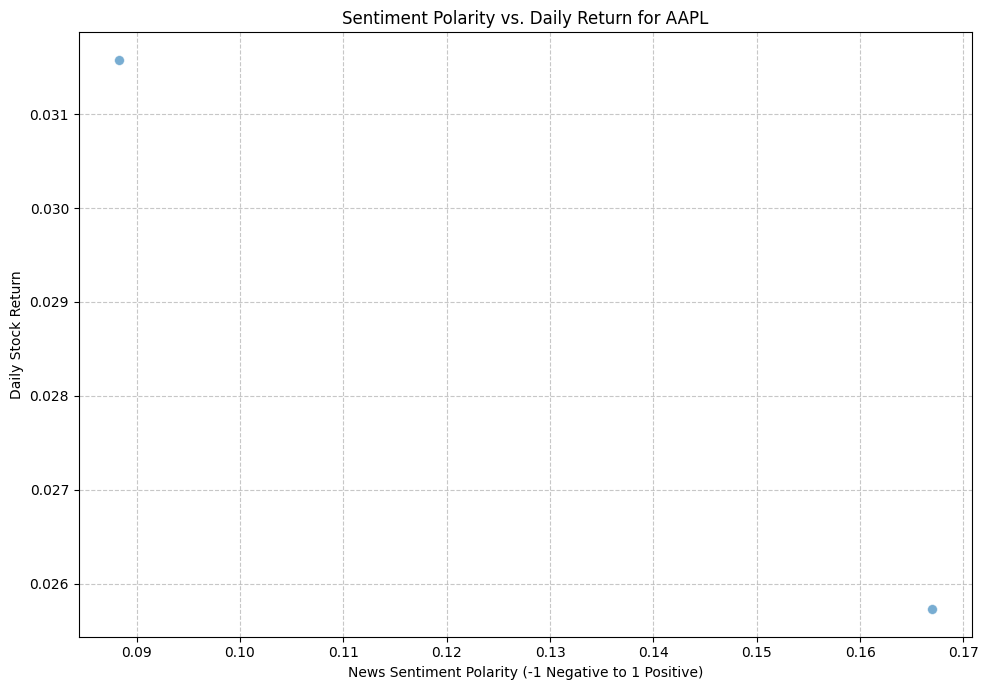

Scatter plot for AAPL saved to ./correlation_plots\AAPL_sentiment_return_scatter_plot.png

--- Interpretation of Correlation Results ---
A correlation coefficient close to:
  - 1 indicates a strong positive linear relationship (positive sentiment tends to coincide with positive returns).
  - -1 indicates a strong negative linear relationship (positive sentiment tends to coincide with negative returns).
  - 0 indicates a weak or no linear relationship.

Consider the magnitude and sign of the correlations. Very low correlations (close to 0) suggest that daily news sentiment, as measured, doesn't have a strong immediate linear relationship with daily stock returns for that company.
Factors to consider:
  - **Lag effects:** News sentiment might influence returns on subsequent days, not just the same day.
  - **News volume vs. quality:** Not all news is equally impactful.
  - **Market efficiency:** In highly efficient markets, information is priced in quickly, reducing the observable correl

In [6]:
# --- Interpret and Visualize Correlation Results ---
print("\n--- Interpreting and Visualizing Correlation Results ---")

if not correlation_df.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(x='STOCK_SYMBOL', y='Correlation_Sentiment_Return', data=correlation_df, palette='coolwarm')
    plt.title('Correlation Between News Sentiment and Daily Stock Returns by Company')
    plt.xlabel('Stock Symbol')
    plt.ylabel('Correlation Coefficient')
    plt.axhline(0, color='black', linestyle='--', linewidth=0.8) # Add a line at 0 for reference
    plt.ylim(-1, 1) # Correlation ranges from -1 to 1
    plt.grid(axis='y', alpha=0.7)
    plt.tight_layout()
    plt.savefig(os.path.join(correlation_plots_dir, 'sentiment_return_correlation_bar_chart.png'))
    plt.show()
    print(f"Correlation bar chart saved to {os.path.join(correlation_plots_dir, 'sentiment_return_correlation_bar_chart.png')}")

    # Optional: Scatter plot for a sample stock to visualize the relationship
    if not df_merged.empty:
        sample_stock_for_scatter = df_merged['STOCK_SYMBOL'].unique()[0]
        df_sample_scatter = df_merged[df_merged['STOCK_SYMBOL'] == sample_stock_for_scatter]

        if not df_sample_scatter.empty:
            plt.figure(figsize=(10, 7))
            sns.scatterplot(x='sentiment_polarity', y='Daily_Return', data=df_sample_scatter, alpha=0.6, s=50)
            plt.title(f'Sentiment Polarity vs. Daily Return for {sample_stock_for_scatter}')
            plt.xlabel('News Sentiment Polarity (-1 Negative to 1 Positive)')
            plt.ylabel('Daily Stock Return')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.savefig(os.path.join(correlation_plots_dir, f'{sample_stock_for_scatter}_sentiment_return_scatter_plot.png'))
            plt.show()
            print(f"Scatter plot for {sample_stock_for_scatter} saved to {os.path.join(correlation_plots_dir, f'{sample_stock_for_scatter}_sentiment_return_scatter_plot.png')}")
        else:
            print(f"No data for scatter plot for {sample_stock_for_scatter}.")
    else:
        print("Merged data is empty, cannot generate scatter plot.")
else:
    print("No correlation results to visualize.")


print("\n--- Interpretation of Correlation Results ---")
print("A correlation coefficient close to:")
print("  - 1 indicates a strong positive linear relationship (positive sentiment tends to coincide with positive returns).")
print("  - -1 indicates a strong negative linear relationship (positive sentiment tends to coincide with negative returns).")
print("  - 0 indicates a weak or no linear relationship.")
print("\nConsider the magnitude and sign of the correlations. Very low correlations (close to 0) suggest that daily news sentiment, as measured, doesn't have a strong immediate linear relationship with daily stock returns for that company.")
print("Factors to consider:")
print("  - **Lag effects:** News sentiment might influence returns on subsequent days, not just the same day.")
print("  - **News volume vs. quality:** Not all news is equally impactful.")
print("  - **Market efficiency:** In highly efficient markets, information is priced in quickly, reducing the observable correlation.")
print("  - **Sentiment model:** The TextBlob model is relatively simple; more sophisticated NLP models might yield different results.")
print("  - **Data granularity:** Aggregating all news to a single daily sentiment might smooth out important nuances.")

print("\n--- Task 3 Complete ---")
